# STYLE TRANSFER

This project involves artistic style transfer - the ability to use machine learning algorithms to apply the style of a particular image onto another image. 

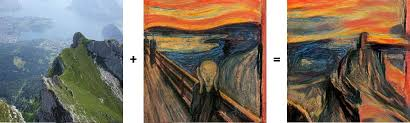

Optimization deals with asking the question:

**How to measure the difference between Content Image  and Style Image ? **

-> Posing it as a cost / loss function : Content Loss, Style Loss (Mentioned below in detail)

->  The content loss tends to 0 if the input image is similar to the style image in terms of content

->  The style loss tends to 0 if the input image is similar to the style image in terms of style


The core concept was introduced by [Gatys el al. (2015)](https://arxiv.org/pdf/1508.06576.pdf) is that convulutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images.

In [1]:
# Image URLs to feed in. To change just change the URL itself
content_image_url = "https://i.ibb.co/zHgRHqn/13256552-10208344517163398-1943207495614137527-n.jpg"
style_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

# Request to Download images
import requests

content_filename = content_image_url.split('/')[-1]
r = requests.get(content_image_url, allow_redirects=True)
open(content_filename, 'wb').write(r.content)

style_filename = style_image_url.split('/')[-1]
r = requests.get(style_image_url, allow_redirects=True)
open(style_filename, 'wb').write(r.content)

613563

In [2]:
#installing pytorch 1.1.0 and wheel which is designed to contain all the files for a PEP 376 compatible install in a way that is very close to the on-disk format
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\10/'    
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
version='1.1.0'

torch_url=f"http://download.pytorch.org/whl/{accelerator}/torch-{version}-{platform}-linux_x86_64.whl"

!pip install -U {torch_url} torchvision


import torch
print(torch.__version__)

     |████████████████████████████████| 770.7MB 4.3MB/s 
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.3.0)
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
1.1.0


In [3]:
# Non colab imports
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
print("Dependencies installed")

Dependencies installed


In [0]:
'''Load image having pixels in X and Y less than 500 pixels as larger image would be computationally heavy'''

def load_image(img_path, max_size=400, shape = None):

    image = Image.open(img_path).convert('RGB') 

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    #Composes several transforms together
    in_transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

    # Discarding the transparency and adding the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

  
  
#Converting image from tensor to numpy
def convert_image(tensor):
    
    #Just like creating a new tensor -> reads out ‘the data’ from tensor variable, and constructs a leaf variable
    image = tensor.to("cpu").clone().detach()
    #Converting to numpy and removing single-dimensional entries from the shape of an array
    image = image.numpy().squeeze()
    #swapping axes 1 and 2 while keeping axis 0 constant/unchanged
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    #clipping values above 1 as 1 and below 0 as 0
    image = image.clip(0, 1)

    return image

# VGG NETWORK

The VGG network architecture was introduced by Simonyan and Zisserman in their 2014 paper,[ Very Deep Convolutional Networks for Large Scale Image Recognition](https://arxiv.org/abs/1409.1556). It won the  ImageNet Challenge 2014 by achieving state of the art results.



![alt text](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)



Characteristics of this network was it's Simplicity. It used 3* 3 convolution layer stacked on top of each other. There are  19 layers in total. 16 Convulution layer followed by 3 fully connected layers each having 4096 nodes which is followed by a softmax classifier. Pooling means is MaxPooling.

In [8]:
vgg = models.vgg19(pretrained=True).features
# Getting  the "features" using VGG19 model as explained above

# Using GPU of colab if switched on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

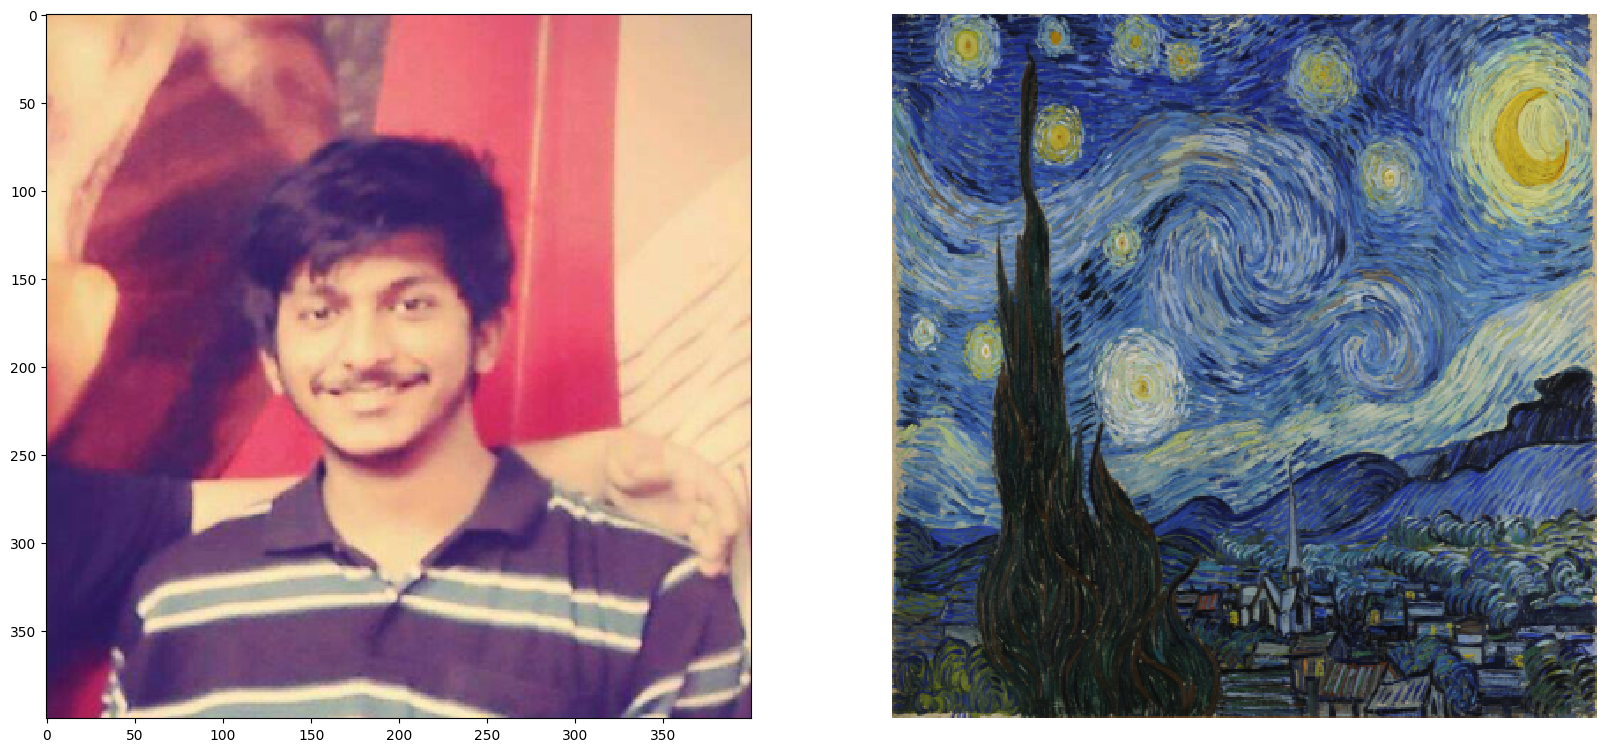

In [9]:
plt.style.use('default')

# Load in content and style image
content = load_image(content_filename).to(device)
# Resizing style image to match content image dimensions
style = load_image(style_filename, shape=content.shape[-2:]).to(device)

#Display Images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_image(content))
plt.axis('off')
ax2.imshow(convert_image(style))
plt.axis('off')
plt.savefig("content_and_style.png", bbox_inches='tight', pad_inches=0)
plt.show()

# **Gram Matrix**: Roughly an empirical covariance matrix
The gram matrix is a covariance of filters.

A filter picks up certain shapes and features such as circles in this case.

A covariance among these would include which images have lots of these features.

What's being measured is whether, at a particular pixel position, feature #X tends to co-occur with feature #Y. In style transfer, we generate the gram matrix of the activations of a particular layer's features on the Van Gogh's painting.

The idea is that say, in Van Gogh's paintings, whenever you have feature #15 lit up at a particular point, feature #8 also lights up. 

Then you optimize the target image such that the pattern of cooccurrence of features matches the Van Gogh's.

Gatys best results were achieved by taking combination of deep and shallow convolution layers as the style representation of an image.

![alt text](https://miro.medium.com/max/508/1*ZJjUFPPqLZ1z48maIfInBA.png)




In [0]:
def get_features(image, model, layers=None):
    """ 
    Getting features of the image using the VGG model passed. The features will be extracted from particular layers of VGG 19.
    """

    # The first layer of each block is Style Representation
    # Representation of content
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}

    features = {}
    x = image.to(device)
    
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

def gram_matrix(tensor):
    """ 
    Calculate the Gram Matrix of a given tensor 
    """

    # Get the batch_size, depth, height, and width of the Tensor
    
    _, d, h, w = tensor.size()
    
    # Reshaping it, so we can multiplying the features for each channel
    tensor = tensor.view(d, h*w)

    # Calculation of GRAM MATRIX
    gram = torch.mm(tensor, tensor.t())

    return gram


# Content Weight and Style Weight

Even if the initial images look very different, after being passed through many internal layers, their representations will be very close in raw value.

The summation notation makes the concept look harder than it really is. Basically, we make a list of layers at which we want to compute content loss. We pass the content and pastiches images through the network until a particular layer in the list, take the output of that layer, square the difference between each corresponding value in the output, and sum them all up. We do this for every layer in the list, and sum those up. One thing to note, though: we multiply each of the representations by some value **alpha - called the content weight** before finding their differences and squaring it, whereas the original equation calls for the value to be multiplied after squaring it.

                                  Content Loss
![alt text](https://miro.medium.com/max/700/1*9F6OMenk4_lsCyoM5XA4xA.png)



Similar to our style loss computation, we find the Euclidean distances between each corresponding pair of values in the Gram matrices computed at each layer in a predefined list of layers, multiplied by some value **beta -known as the style weight**.

![alt text](https://miro.medium.com/max/700/1*R3Ler_uVVldfdRSYmeLKjw.png)


Capturing information about the style of the image is not straightforward. However,  [Gatys el al. (2015)](https://arxiv.org/pdf/1508.06576.pdf) research paper found that we can extract a style representation by looking at the spatial correlation of values with an activation or feature map which was calculated by the **Gram Matrix**.

In [0]:

'''Getting features of content image and style image using our vgg model'''
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


#Calculating the Gram Matrix for each layer present
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


# Creating another copy of content image
# requires_grad=True so that torch.autograd records operations on them for automatic differentiation hence the image will change it's style with each iteration
target = content.clone().requires_grad_(True).to(device)



# Weighing each layers features according to the proportion of contribution to the style , conv4_2 is excluded as it is the content representation itself
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# A higher style weight may make content unrecognizable
content_weight = 1  # alpha in paper
style_weight = 1e9  # beta in paper

# Show target image every x steps
show_every = 400

#Adam Optimizer is used to update weights
optimizer = optim.Adam([target], lr=0.003)

#iterations required to bring the loss function below a certain threshold
steps = 2000

# Training Loop
for ii in range(1, steps+1):
    if ii % 100 == 0:
      print("Step #", ii, '/', steps)
      
    # Calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Initialize style loss to 0
    # The world was perfect before the model started training
    style_loss = 0
    
    # Iterate through each style layer and add to the style loss
    for layer in style_weights:
        # Get the target (goal) style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        # Calculate the target gram matrix
        target_gram = gram_matrix(target_features[layer])

        # Get the style representation
        style_gram = style_grams[layer]

        # Calculate the weighted style loss for one layer
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        # Adding style loss
        style_loss += layer_style_loss / (d * h * w)


    #Getting Total loss by adding content loss and style loss in proportion to their weights 
    total_loss = (content_loss * content_weight) + (style_loss * style_weight)

    # Updating target image
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)
    optimizer.step()

    # Displaying intermediate image and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(convert_image(target))
        plt.axis('off')
        plt.savefig("result_" + str(ii) + ".png", bbox_inches='tight', pad_inches=0)
        plt.show()


# Display conetnt and style image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_image(content))
ax2.imshow(convert_image(target))

plt.savefig("style_transfer.png", bbox_inches='tight', pad_inches=0)

plt.show()


Step # 100 / 2000
